In [1]:
# ============================================
# SVM — Step 1: Load preprocessing
# ============================================

%run "./02_preprocessing.ipynb"

import numpy as np
import pandas as pd

from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve
)

import matplotlib.pyplot as plt
import seaborn as sns

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("\nClass distribution:\n", y_train.value_counts(normalize=True))


Initial shape: (15000, 17)
Exact duplicate rows: 0
Duplicate faculty_id: 0


,faculty_id,academic_rank,tenure_status,years_at_institution,base_salary,teaching_load,research_funding,institution_type,department_size,admin_support,work_life_balance,department_collaboration,promotion_opportunities,publications_last_3_years,student_evaluation_avg,job_market_alternatives,left_institution
0,1,Associate Professor,Tenure-Track,3,70974.758663,6,9960.082453,Community College,Medium,1,3,8,1,7,3.520074,9,0
1,2,Full Professor,Non-Tenure,16,69482.774557,3,108309.536130,Liberal Arts College,Medium,3,3,2,9,4,3.811163,4,0
2,3,Lecturer,Non-Tenure,19,91434.392986,2,10044.468010,Research University,Medium,9,5,9,3,4,3.539667,7,0
3,4,Associate Professor,Non-Tenure,24,65850.710135,6,4159.726828,Research University,Small,5,7,6,1,5,4.351417,9,1
4,5,Associate Professor,Non-Tenure,39,30000.000000,7,10718.111809,Community College,Small,6,6,8,8,5,3.932108,2,0


Train shape: (12000, 15)
Test shape: (3000, 15)

Train target distribution:
left_institution
0    0.726667
1    0.273333
Name: proportion, dtype: float64
Categorical columns: ['academic_rank', 'tenure_status', 'institution_type', 'department_size']
Numeric columns: ['years_at_institution', 'base_salary', 'teaching_load', 'research_funding', 'admin_support', 'work_life_balance', 'department_collaboration', 'promotion_opportunities', 'publications_last_3_years', 'student_evaluation_avg', 'job_market_alternatives']
Preprocessor fitted successfully!
Processed shape: (12000, 40)
X_train shape: (12000, 15)
X_test shape: (3000, 15)

Class distribution:
 left_institution
0    0.726667
1    0.273333
Name: proportion, dtype: float64


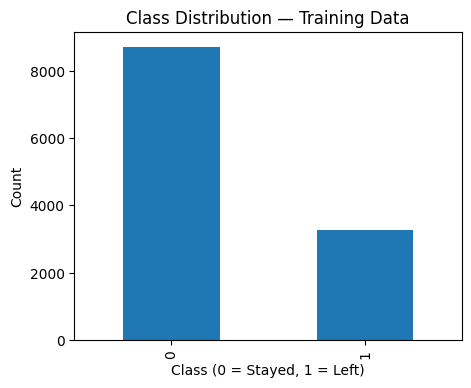

In [2]:
plt.figure(figsize=(5,4))
y_train.value_counts().plot(kind='bar')
plt.title("Class Distribution — Training Data")
plt.xlabel("Class (0 = Stayed, 1 = Left)")
plt.ylabel("Count")
plt.show()


In [3]:
# ============================================
# BASELINE LINEAR SVM (LinearSVC)
# ============================================

svm_linear = Pipeline([
    ("preprocess", preprocessor),
    ("svm", LinearSVC(
        C=1.0,
        max_iter=5000
    ))
])

svm_linear.fit(X_train, y_train)

y_pred_svm_linear = svm_linear.predict(X_test)

print("Linear SVM Accuracy:", accuracy_score(y_test, y_pred_svm_linear))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm_linear))


Linear SVM Accuracy: 0.759

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.95      0.85      2180
           1       0.65      0.25      0.36       820

    accuracy                           0.76      3000
   macro avg       0.71      0.60      0.61      3000
weighted avg       0.74      0.76      0.72      3000



In [4]:
# ============================================
# LINEAR SVM — WITH CLASS WEIGHTS
# ============================================

svm_linear_weighted = Pipeline([
    ("preprocess", preprocessor),
    ("svm", LinearSVC(
        C=1.0,
        class_weight="balanced",
        max_iter=5000
    ))
])

svm_linear_weighted.fit(X_train, y_train)

y_pred_lin_w = svm_linear_weighted.predict(X_test)

print("Weighted Linear SVM Accuracy:", accuracy_score(y_test, y_pred_lin_w))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lin_w))


Weighted Linear SVM Accuracy: 0.6636666666666666

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.65      0.74      2180
           1       0.43      0.70      0.53       820

    accuracy                           0.66      3000
   macro avg       0.64      0.67      0.63      3000
weighted avg       0.74      0.66      0.68      3000



In [5]:
# ============================================
# RBF SVM (SVC with probability=True)
# ============================================

svm_rbf = Pipeline([
    ("preprocess", preprocessor),
    ("svm", SVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",
        class_weight="balanced",
        probability=True
    ))
])

svm_rbf.fit(X_train, y_train)

y_pred_rbf = svm_rbf.predict(X_test)
y_prob_rbf = svm_rbf.predict_proba(X_test)[:, 1]

print("RBF SVM Accuracy:", accuracy_score(y_test, y_pred_rbf))
print("RBF SVM AUC:", roc_auc_score(y_test, y_prob_rbf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rbf))


RBF SVM Accuracy: 0.664
RBF SVM AUC: 0.7586960170060417

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.63      0.73      2180
           1       0.43      0.75      0.55       820

    accuracy                           0.66      3000
   macro avg       0.65      0.69      0.64      3000
weighted avg       0.75      0.66      0.68      3000



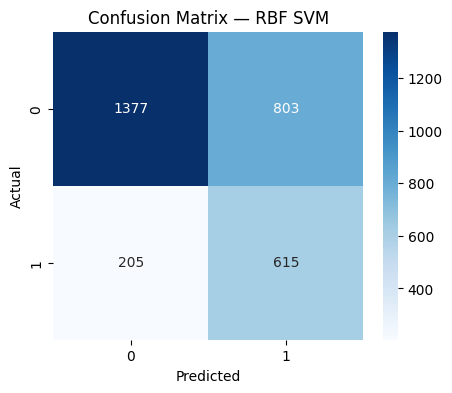

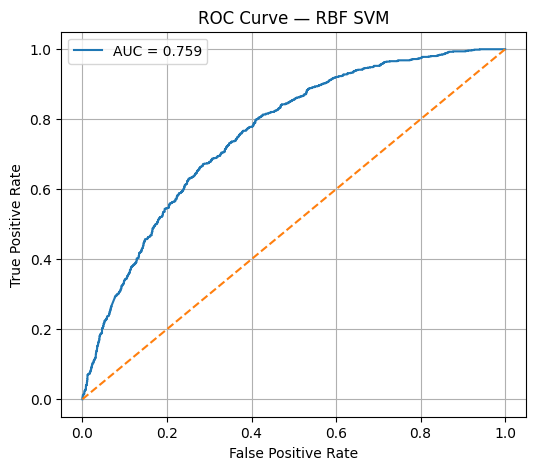

In [6]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rbf)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — RBF SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_rbf)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob_rbf):.3f}")
plt.plot([0,1],[0,1],"--")
plt.title("ROC Curve — RBF SVM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# ============================================
# RBF SVM — Hyperparameter Tuning
# ============================================

from sklearn.model_selection import GridSearchCV

svm_rbf_tune = Pipeline([
    ("preprocess", preprocessor),
    ("svm", SVC(
        kernel="rbf",
        probability=True,
        class_weight="balanced"
    ))
])

param_grid_svm = {
    "svm__C": [0.1, 1, 5, 10],
    "svm__gamma": ["scale", 0.1, 0.01, 0.001]
}

grid_svm = GridSearchCV(
    estimator=svm_rbf_tune,
    param_grid=param_grid_svm,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1
)

grid_svm.fit(X_train, y_train)

print("Best Params:", grid_svm.best_params_)
print("Best CV AUC:", grid_svm.best_score_)


In [ ]:
best_svm = grid_svm.best_estimator_

y_pred_svm_final = best_svm.predict(X_test)
y_prob_svm_final = best_svm.predict_proba(X_test)[:, 1]

print("Final SVM Accuracy:", accuracy_score(y_test, y_pred_svm_final))
print("Final SVM AUC:", roc_auc_score(y_test, y_prob_svm_final))
print("\nFinal Classification Report:\n", classification_report(y_test, y_pred_svm_final))

cm = confusion_matrix(y_test, y_pred_svm_final)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Final Tuned SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
